#Clustering Analysis - Breakfast Cereals

With a set of nutritional data, consisting of 14 features for 77 different cereals, we can explore unsupervised machine learning techniques known as clustering. Once our data has been prepared properly, we can use different methods to group the cereals together and look for meaningful patterns in the clusters.

First, we import the required packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy
from sklearn.preprocessing import Imputer

%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

##Data import and cleaning

Then read in the data, replacing missing values with None (first pass):

In [2]:
data = pd.read_csv('cereals.csv')  # next time set na_values=-1... to simplify this
print('Missing (-1) values:\n', data[data==-1].dropna(how='all',axis=[0,1]))
columns = data[data==-1].dropna(how='all',axis=[0,1]).columns
for col in columns:
    data.loc[data[col]==-1, col] = None# int(data[col].mean())
    # Use None here instaed of the mean, especially since the -1 will affect mean()
data = pd.get_dummies(data, columns=['mfr','type'])  # Convert mfr and type to numbers
data.head()

Missing (-1) values:
     carbo  sugars  potass
4     NaN     NaN      -1
20    NaN     NaN      -1
57     -1      -1     NaN


,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
0,100%_Bran,70,4,1,130,10,5,6,280,25,...,0.33,0,0,0,1,0,0,0,1,0
1,100%_Natural_Bran,120,3,5,15,2,8,8,135,0,...,1.00,0,0,0,0,0,1,0,1,0
2,All-Bran,70,4,1,260,9,7,5,320,25,...,0.33,0,0,1,0,0,0,0,1,0
3,All-Bran_with_Extra_Fiber,50,4,0,140,14,8,0,330,25,...,0.50,0,0,1,0,0,0,0,1,0
4,Almond_Delight,110,2,2,200,1,14,8,NaN,25,...,0.75,0,0,0,0,0,0,1,1,0


In [3]:
data[data==-1].dropna(how='all',axis=[0,1])  # Verify the -1s are removed

""


Now we'll look for correlations between features (columns), filtering out anything with a low score (not correlated)

In [4]:
corrs = data.corr()
for i in range(len(corrs)):
    # Replace all the diagonals with None, so they can be dropped
    corrs.ix[i,i] = None
sig = corrs[(corrs>0.5) | (corrs < -0.5)].dropna(how='all', axis=[0,1]) # Drop insignificant row/col
sig

,calories,protein,fiber,sugars,potass,weight,cups,mfr_A,type_C,type_H
calories,NaN,NaN,NaN,0.566533,NaN,0.696091,NaN,NaN,NaN,NaN
protein,NaN,NaN,0.500330,NaN,0.563706,NaN,NaN,NaN,NaN,NaN
fiber,NaN,0.500330,NaN,NaN,0.911528,NaN,-0.513061,NaN,NaN,NaN
sugars,0.566533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
potass,NaN,0.563706,0.911528,NaN,NaN,NaN,-0.501607,NaN,NaN,NaN
weight,0.696091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cups,NaN,NaN,-0.513061,NaN,-0.501607,NaN,NaN,NaN,NaN,NaN
mfr_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.569703,0.569703
type_C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.569703,NaN,-1.000000
type_H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569703,-1.000000,NaN


We can also plot a (very dense) diagram plotting each feature against another to visually see correlations or lack thereof.

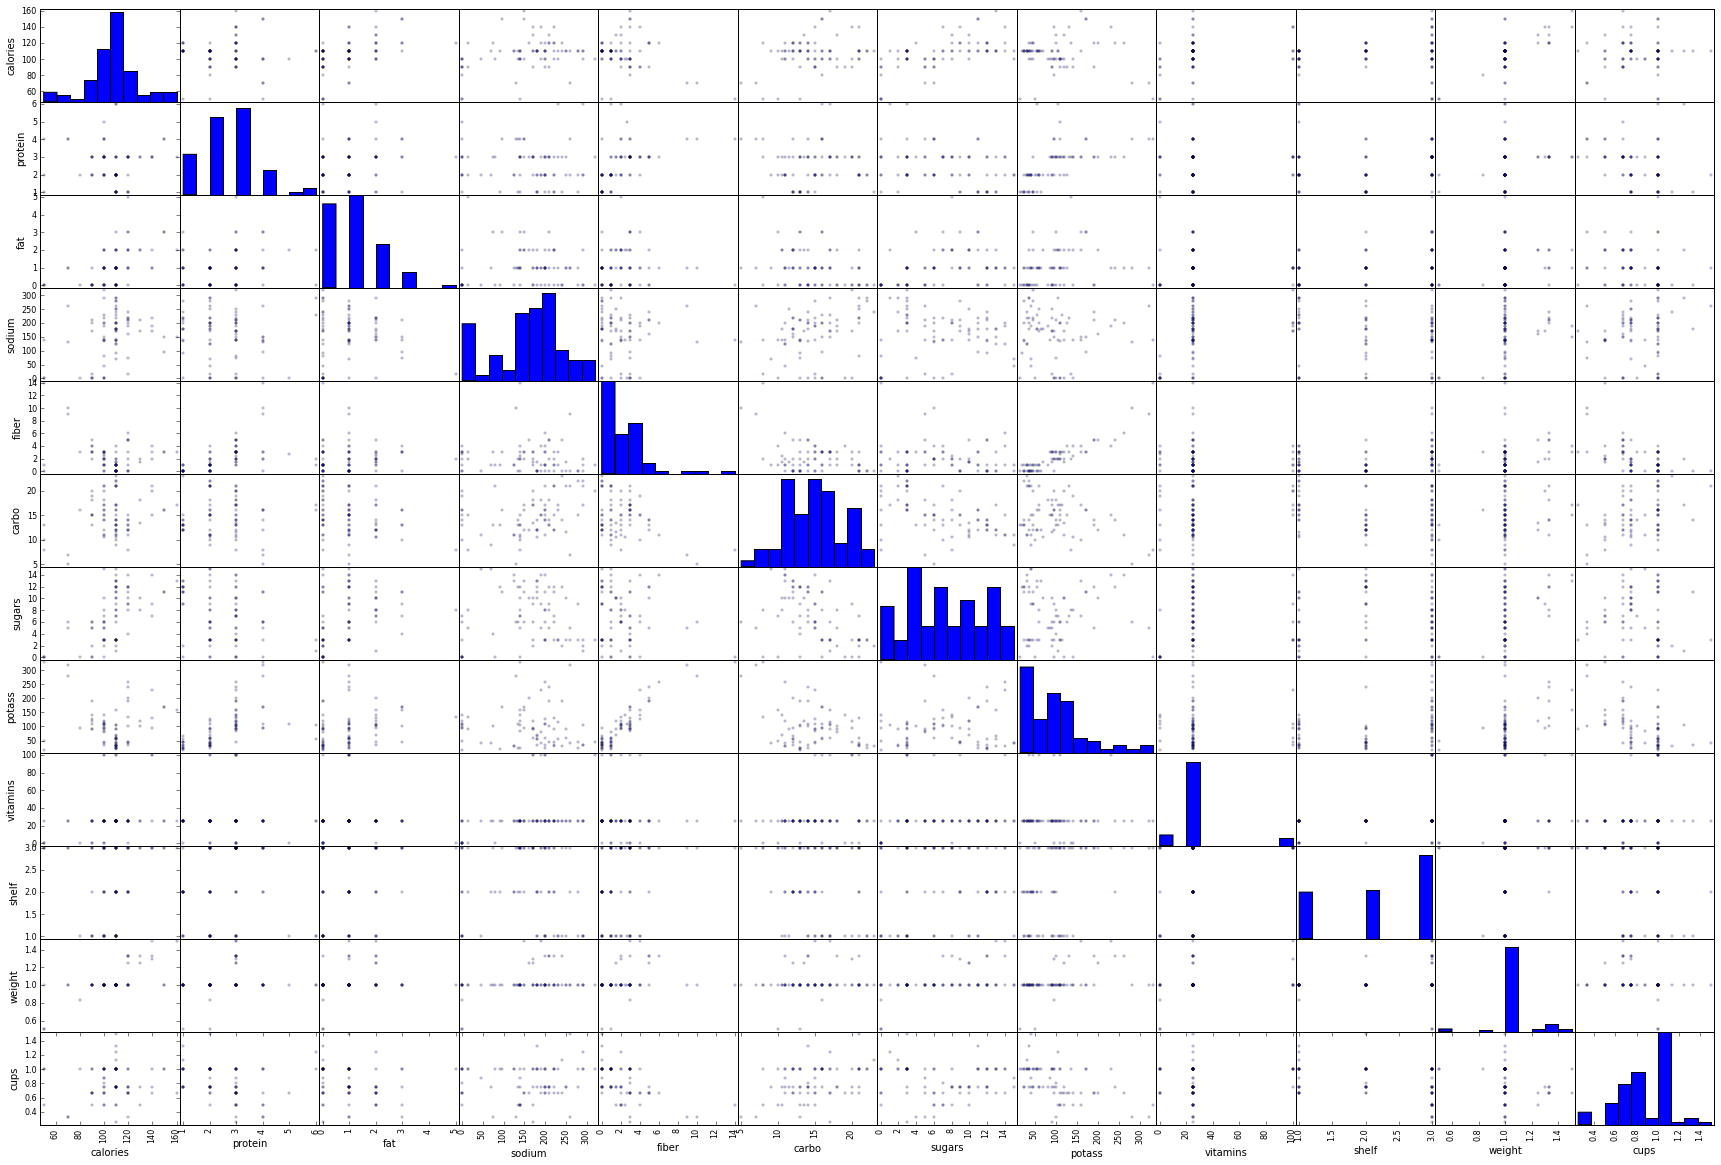

In [5]:
scatter_matrix(data.ix[:,:-9], alpha=0.2, figsize=(30, 20), diagonal='hist');

###Observations:
- Both sugar and weight have a positive correlation with total calories, which is not too surprising
- Protein is mildly correlated with both fiber and potassium content
- Fiber is also strongly positively correlated with potassium content
- On the other hand, fiber is negatively correlated with the volume (cups) of a cereal (a little goes a long way)
- For the categorical data, we learn that cold cereals are never hot in this data set, and that manufacturer "A" favors hot cereals
- We can make an educated guess to replace the two missing potassium values (using linear regression), but there are no strong correlations to help us with the sugar or carb content

###We can replace 2 of the 4 missing values with linear regression

In [6]:
data.iloc[[4,20,57]].ix[:,:-9]

,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
4,Almond_Delight,110,2,2,200,1.0,14,8,NaN,25,3,1,0.75
20,Cream_of_Wheat_(Quick),100,3,0,80,1.0,21,0,NaN,0,2,1,1.00
57,Quaker_Oatmeal,100,5,2,0,2.7,NaN,NaN,110,0,1,1,0.67


In [7]:
#Now do linear regression on fiber

from sklearn.linear_model import LinearRegression
from sklearn.cluster import MeanShift, estimate_bandwidth
not_missing = data.dropna(how='any')
lr = LinearRegression()
y = not_missing['potass']
x = not_missing['fiber'].to_frame()
lr.fit(x,y)
lr.predict(1) # both missing potassium values have fiber content of 1.0


array([ 67.1707])

In [8]:
#data.ix['potass', 4] = lr.predict(1)   # incorrect syntax
data.loc[4, 'potass'] = lr.predict(1) # one way to do it
data.set_value(20, 'potass', lr.predict(1)) # more performant way
data.iloc[[4,20,57]].ix[:,:-9]


,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
4,Almond_Delight,110,2,2,200,1.0,14,8,67.170686,25,3,1,0.75
20,Cream_of_Wheat_(Quick),100,3,0,80,1.0,21,0,67.170686,0,2,1,1.00
57,Quaker_Oatmeal,100,5,2,0,2.7,NaN,NaN,110.000000,0,1,1,0.67


###Now we can use the Imputer to fill in the other two with the mean across the dataset

In [9]:
data = data.set_index('name') # Get all strings out of columns, so that we can impute the mean
data.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
name,,,,,,,,,,,,,,,,,,,,,
100%_Bran,70,4,1,130,10,5,6,280.000000,25,3,...,0.33,0,0,0,1,0,0,0,1,0
100%_Natural_Bran,120,3,5,15,2,8,8,135.000000,0,3,...,1.00,0,0,0,0,0,1,0,1,0
All-Bran,70,4,1,260,9,7,5,320.000000,25,3,...,0.33,0,0,1,0,0,0,0,1,0
All-Bran_with_Extra_Fiber,50,4,0,140,14,8,0,330.000000,25,3,...,0.50,0,0,1,0,0,0,0,1,0
Almond_Delight,110,2,2,200,1,14,8,67.170686,25,3,...,0.75,0,0,0,0,0,0,1,1,0


In [10]:
data.iloc[[4,20,57]].ix[:,:-9]

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
name,,,,,,,,,,,,
Almond_Delight,110,2,2,200,1.0,14,8,67.170686,25,3,1,0.75
Cream_of_Wheat_(Quick),100,3,0,80,1.0,21,0,67.170686,0,2,1,1.00
Quaker_Oatmeal,100,5,2,0,2.7,NaN,NaN,110.000000,0,1,1,0.67


In [11]:
imp = Imputer(missing_values='NaN', strategy='mean')#, axis=0)#, verbose=0, copy=True)
df = pd.DataFrame(imp.fit_transform(data), columns=data.columns, index=data.index)
df.iloc[56:59]  #Note Quaker_Oatmeal sugar and carbo NaN's have been filled in

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
name,,,,,,,,,,,,,,,,,,,,,
Quaker_Oat_Squares,100,4,1,135,2.0,14.000000,6.000000,110,25,3,...,0.50,0,0,0,0,0,1,0,1,0
Quaker_Oatmeal,100,5,2,0,2.7,14.802632,7.026316,110,0,1,...,0.67,0,0,0,0,0,1,0,0,1
Raisin_Bran,120,3,1,210,5.0,14.000000,12.000000,240,25,2,...,0.75,0,0,1,0,0,0,0,1,0


In [12]:
## May need to normalize to something (maybe calories), 
## but test as is (appears to be normalized to 1 serving)

##Now we are ready to perform clustering tasks

In [13]:
kmeans = KMeans(5)
scaled = preprocessing.scale(df)
kmeans.fit(scaled)
clusters = (kmeans.predict(scaled))
print(kmeans.cluster_centers_)
print(clusters)
#centroids, clusters = kmeans(img_data, 3)

[[-0.6508 -0.2388  0.7014 -0.6479 -0.4262 -0.8379 -0.2044 -0.4127 -0.629
   0.4397 -1.1537  0.1067 -0.1147 -0.6325 -0.6526 -0.2907 -0.3638  2.9368
  -0.3405  0.2013 -0.2013]
 [-0.1085 -0.3416 -0.3391  0.1462 -0.3671  0.2372 -0.0564 -0.4724  0.0741
  -0.4352 -0.2228  0.3622 -0.1147  0.1856  0.0598  0.0337 -0.0931 -0.3405
   0.087   0.2013 -0.2013]
 [-1.9054  1.1075 -0.513   0.3041  3.1033 -1.6992 -0.7003  2.632  -0.1463
   0.9578 -0.1981 -1.5724 -0.1147 -0.6325  0.4398  0.642   0.4143 -0.3405
  -0.3405  0.2013 -0.2013]
 [-0.3556  1.3373 -0.013  -1.597  -0.388   0.6392 -0.8525 -0.103  -0.8971
  -0.6542 -0.1981  0.2983  2.8295 -0.6325 -0.6526  0.9529 -0.3638  0.7519
  -0.3405 -4.9666  4.9666]
 [ 1.0727  0.5261  0.7518  0.0816  0.5072 -0.0098  0.552   0.8471  0.2512
   0.8867  1.1594 -0.7067 -0.1147  0.0186  0.1185 -0.2907  0.3686 -0.3405
   0.0451  0.2013 -0.2013]]
[2 0 2 2 1 1 1 4 1 2 0 1 1 4 1 1 1 1 1 4 3 1 1 1 1 1 1 4 4 1 1 1 1 4 4 0 1
 1 1 4 1 0 1 3 4 4 4 1 1 4 1 4 4 1 0 0 0 3 4 4 1 1

In [17]:
columns = df.columns #ix[:,:-2].columns
index = df.index
ss = pd.DataFrame(scaled, columns=columns, index=index) #scaled version


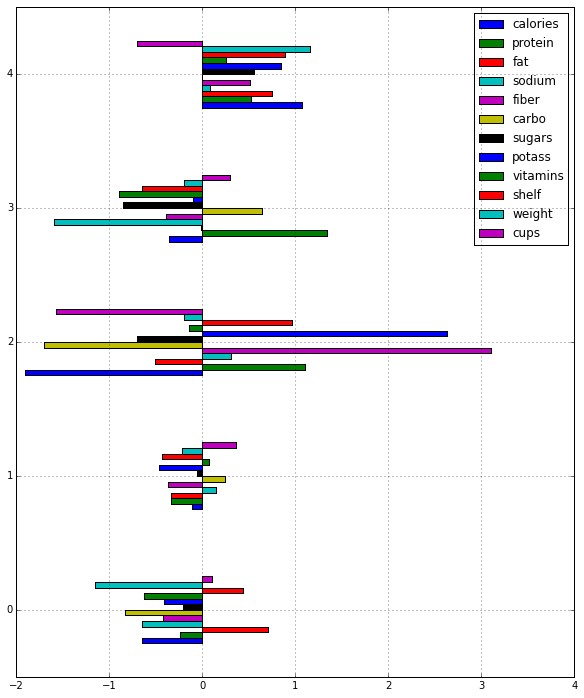

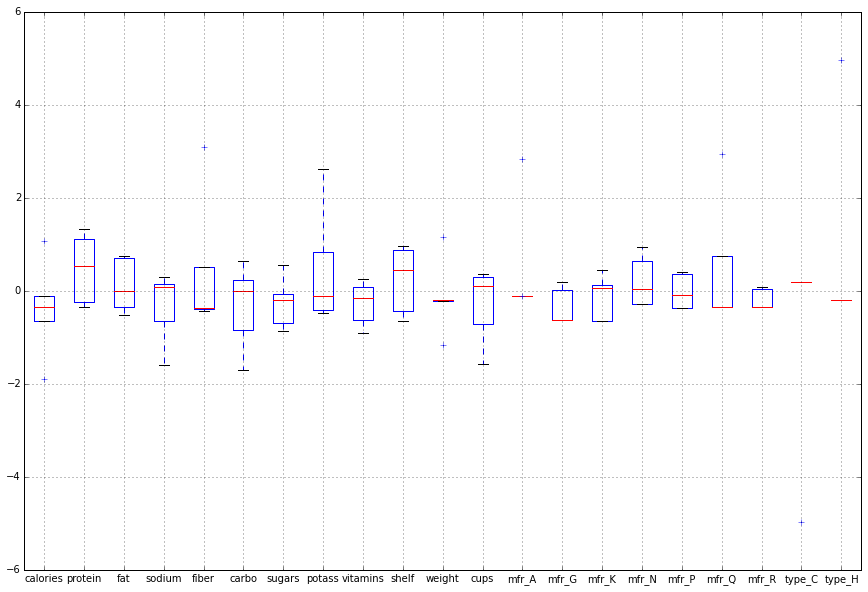

In [18]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)
centroids.ix[:,:-9].plot(figsize=(10,12), kind='barh')
# centroids.plot(figsize=(15,10), kind='box')
centroids.plot(figsize=(15,10), kind='box')
# centroids.plot(figsize=(15,10), kind='line')
# df.plot()

In [30]:
labels = {0: 'Low Everything',
 1: 'Low Sodium, High Protein',
 2: 'High Everything (Except Carbs)',
 3: 'Sugary, Low-Vitamin',
 4: 'High Carb, Low Sugar',
}


###Above we can see the spread centroid coordinates in each dimension

In [31]:
df[df<0].dropna(how='all')  # no negative values

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,cups,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H
name,,,,,,,,,,,,,,,,,,,,,


In [32]:
ss['label'] = np.array(clusters)

In [33]:
ss.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H,label,name
name,,,,,,,,,,,,,,,,,,,,,
Cap'n'Crunch,0.677623,-1.420902,0.987096,0.724306,-0.908824,-0.726777,1.150938,-0.908126,-0.14627,-0.251230,...,-0.632456,-0.652630,-0.290701,-0.363803,2.936835,-0.340503,0.201347,-0.201347,2,100%_Natural_Bran
Bran_Chex,-0.872189,-0.501495,-0.012988,0.484170,0.780481,0.051181,-0.237495,0.392322,-0.14627,-1.460273,...,-0.632456,-0.652630,-0.290701,-0.363803,-0.340503,2.936835,0.201347,-0.201347,0,Cap'n'Crunch
Raisin_Squares,-0.872189,-0.501495,-1.013072,-1.917189,-0.064172,0.051181,-0.237495,0.175581,-0.14627,0.957813,...,-0.632456,1.532262,-0.290701,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,2,Honey_Graham_Ohs
Shredded_Wheat_'n'Bran,-0.872189,0.417912,-1.013072,-1.917189,0.780481,1.088459,-1.625929,0.609063,-1.27255,-1.460273,...,-0.632456,-0.652630,3.439961,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,2,Life
All-Bran,-1.905397,1.337319,-0.012988,1.204578,2.892113,-2.023374,-0.468901,3.209959,-0.14627,0.957813,...,-0.632456,1.532262,-0.290701,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,1,Puffed_Rice


In [34]:
ss['name'] = data.index
ss = ss.sort(['label', 'name'])
grouped = ss.set_index(['label', 'name'])
grouped.ix[:,:-9]
grouped.rename(index=labels)

calories  \
label                          name                                               
Low Everything                 100%_Natural_Bran                      -0.872189   
                               Cap'n'Crunch                            0.161019   
                               Honey_Graham_Ohs                       -0.355585   
                               Life                                    0.677623   
                               Puffed_Rice                             0.677623   
                               Puffed_Wheat                           -0.355585   
                               Quaker_Oat_Squares                      0.161019   
Low Sodium, High Protein       Almond_Delight                         -1.905397   
                               Apple_Cinnamon_Cheerios                -2.938605   
                               Apple_Jacks                            -0.872189   
                               Bran_Chex                              -2.938605   
                               Cheerios                                0.161019   
                               Cinnamon_Toast_Crunch                   0.677623   
                               Cocoa_Puffs                            -0.355585   
                               Corn_Chex                               0.161019   
                               Corn_Flakes                             0.161019   
                               Corn_Pops                               0.161019   
                               Count_Chocula                           0.161019   
                               Crispix                                 0.161019   
                               Crispy_Wheat_&_Raisins                 -0.355585   
                               Double_Chex                             0.161019   
                               Froot_Loops                             0.161019   
                               Frosted_Flakes                          0.161019   
                               Frosted_Mini-Wheats                     0.161019   
                               Fruity_Pebbles                         -0.872189   
                               Golden_Crisp                            0.161019   
                               Golden_Grahams                         -1.388793   
                               Grape_Nuts_Flakes                      -0.872189   
                               Honey-comb                              1.194228   
                               Honey_Nut_Cheerios                     -1.905397   
...                                                                         ...   
                               Total_Whole_Grain                       0.161019   
                               Triples                                -0.355585   
                               Trix                                    0.161019   
                               Wheat_Chex                             -0.355585   
                               Wheaties                               -0.355585   
                               Wheaties_Honey_Gold                     2.744040   
High Everything (Except Carbs) 100%_Bran                               0.677623   
                               All-Bran                               -0.872189   
                               All-Bran_with_Extra_Fiber              -0.872189   
                               Bran_Flakes                            -0.355585   
Sugary, Low-Vitamin            Cream_of_Wheat_(Quick)                 -0.355585   
                               Maypo                                   0.677623   
                               Quaker_Oatmeal                         -0.355585   
High Carb, Low Sugar           Basic_4                                -2.938605   
                               Clusters                                0.161019   
                               Cracklin'_Oat_Bran                      0.161019   
    

In [35]:
ss

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,...,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_C,type_H,label,name
name,,,,,,,,,,,,,,,,,,,,,
Bran_Chex,-0.872189,-0.501495,-0.012988,0.484170,0.780481,5.118148e-02,-2.374952e-01,0.392322,-0.14627,-1.460273,...,-0.632456,-0.652630,-0.290701,-0.363803,-0.340503,2.936835,0.201347,-0.201347,0,100%_Natural_Bran
Apple_Cinnamon_Cheerios,0.161019,-0.501495,0.987096,0.244034,-0.275335,-1.115756e+00,6.881272e-01,-0.402396,-0.14627,-1.460273,...,1.581139,-0.652630,-0.290701,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,0,Cap'n'Crunch
Wheat_Chex,-0.355585,0.417912,-0.012988,0.844374,0.358155,5.698204e-01,-9.317120e-01,0.247828,-0.14627,-1.460273,...,-0.632456,-0.652630,-0.290701,-0.363803,-0.340503,2.936835,0.201347,-0.201347,0,Honey_Graham_Ohs
Fruitful_Bran,0.677623,0.417912,-1.013072,0.964442,1.202807,-2.081380e-01,1.150938e+00,1.331534,-0.14627,0.957813,...,-0.632456,1.532262,-0.290701,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,0,Life
Honey_Graham_Ohs,0.677623,-1.420902,0.987096,0.724306,-0.486498,-7.267769e-01,9.195328e-01,-0.763631,-0.14627,-0.251230,...,-0.632456,-0.652630,-0.290701,-0.363803,2.936835,-0.340503,0.201347,-0.201347,0,Puffed_Rice
Life,-0.355585,1.337319,0.987096,-0.116170,-0.064172,-7.267769e-01,-2.374952e-01,-0.041160,-0.14627,-0.251230,...,-0.632456,-0.652630,-0.290701,-0.363803,2.936835,-0.340503,0.201347,-0.201347,0,Puffed_Wheat
Apple_Jacks,0.161019,-0.501495,-1.013072,-0.416340,-0.486498,-9.860964e-01,1.613750e+00,-0.980373,-0.14627,-0.251230,...,-0.632456,1.532262,-0.290701,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,0,Quaker_Oat_Squares
All-Bran,-1.905397,1.337319,-0.012988,1.204578,2.892113,-2.023374e+00,-4.689008e-01,3.209959,-0.14627,0.957813,...,-0.632456,1.532262,-0.290701,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,1,Almond_Delight
All-Bran_with_Extra_Fiber,-2.938605,1.337319,-1.013072,-0.236238,5.003745,-1.764055e+00,-1.625929e+00,3.354453,-0.14627,0.957813,...,-0.632456,1.532262,-0.290701,-0.363803,-0.340503,-0.340503,0.201347,-0.201347,1,Apple_Cinnamon_Cheerios


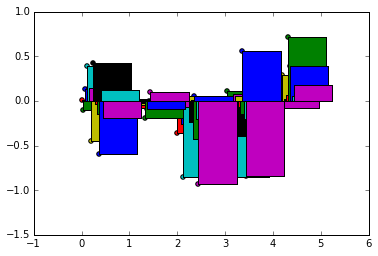

In [39]:
aggs = grouped.ix[:,:-9].groupby(level='label').agg(['mean', 'std'])
means = grouped.groupby(level='label').mean()
# print(means)
# means.plot(kind='line', figsize=(20,10))
# plt.scatter(aggs.index, aggs['sugars'])
# plt.scatter(means.index, means['carbo'])
aggs['sugars']['std']
cols = [col[0] for col in aggs.columns[::2]]
colors ='rgbcmykrgbcmykrgbcmyk'
for i,col in enumerate(cols):
    plt.scatter(x=aggs.index+i/25, y=aggs[col]['mean'], c=colors[i]) #yerr=cols)
    plt.bar(left=aggs.index+i/25, height=aggs[col]['mean'], color=colors[i])

In [38]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit_transform()